In [1]:
import xarray as xr
import numpy as np
import glob  # For file listing
import datetime
import matplotlib.ticker as tkr
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from IPython.display import Image
import yaml
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

In [2]:
# Read the initial conditions of the far-field (from final near-field)

with open("Init.yaml", "r") as file:
    Init = yaml.safe_load(file)

init_lon = Init["init_lon"]
init_lat = Init["init_lat"]

init_depth = Init["init_depth"]
output_dt = Init["output_dt"]  # minutes
ocean_data_path = Init["ocean_data_path"]
parcels_data_path = Init["parcels_data_path"]

npart = Init["npart"]


In [3]:
# Create folder with plots

plot_folder_path = parcels_data_path + "/PLOTS"
os.makedirs(plot_folder_path, exist_ok=True)

In [4]:
# read the parcels simulation output data
    # obs variable is the observation (time)
    # trajectory variable is the specific particle

data_xarray = xr.open_zarr(parcels_data_path)
data_xarray

<xarray.Dataset> Size: 4MB
Dimensions:     (trajectory: 2500, obs: 48)
Coordinates:
  * obs         (obs) int32 192B 0 1 2 3 4 5 6 7 8 ... 40 41 42 43 44 45 46 47
  * trajectory  (trajectory) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499
Data variables:
    lat         (trajectory, obs) float64 960kB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 960kB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 960kB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    w_buoy      (trajectory, obs) float32 480kB dask.array<chunksize=(2500, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 960kB dask.array<chunksize=(2500, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        BuoyParticleAdvectionRK4_3DDiffusionUniformKhDele...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [5]:
# nobs number of observations

nobs = len(data_xarray.obs)

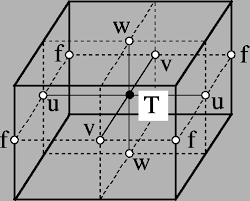

In [6]:
def getRangeIndexes(arr, var_min, var_max):
    return np.where((arr >= var_min) & (arr <= var_max))[0]

Image("arakawaC.png")

In [7]:
#### PLOT CONFIGURATION ##################
# SET GRID LIMITS

all_files = glob.glob(ocean_data_path+"rea*.nc")

ds_mask = xr.open_dataset(ocean_data_path + "mesh_mask.nc")

T_files = [f for f in all_files if "T" in f]
ds_T = xr.open_mfdataset(T_files)

u_files = [f for f in all_files if "U" in f]
ds_u = xr.open_mfdataset(u_files)

v_files = [f for f in all_files if "V" in f]
ds_v = xr.open_mfdataset(v_files)

w_files = [f for f in all_files if "W" in f]
ds_w = xr.open_mfdataset(w_files)


## Configure the spatial temporal range for plotting

####### Set time limits #######
start_date = ds_T.time_counter[0].values  #converts to np.datetime64
end_date = start_date + np.timedelta64(0, 'D')
itimes = getRangeIndexes(ds_u['time_counter'].values, start_date, end_date)
times = ds_u['time_counter'][itimes]

## Set depthT limits gridT 
depthmin_T = ds_T['deptht'].min().values
depthmax_T = ds_T['deptht'].max().values
idepth_T = getRangeIndexes(ds_T['deptht'][:].values, depthmin_T, depthmax_T)
depth_T = ds_T['deptht'][idepth_T]

## Set lat-lon limits gridT 
lonmin = init_lon - 0.1
lonmax = init_lon + 0.1
latmin = init_lat - 0.1
latmax = init_lat + 0.1


ilon_T = getRangeIndexes(ds_mask['glamt'][0,0,:].values, lonmin, lonmax)
ilat_T = getRangeIndexes(ds_mask['gphit'][0,:,0].values, latmin, latmax)
lon2d_T = ds_mask['glamt'][0,ilat_T,ilon_T]
lat2d_T = ds_mask['gphit'][0,ilat_T,ilon_T]

## Set lat-lon limits gridU (same size of gridT)

ilon_U = getRangeIndexes(ds_mask['glamt'][0,0,:].values, lonmin, lonmax)
ilat_U = getRangeIndexes(ds_mask['gphit'][0,:,0].values, latmin, latmax)
lon2d_U = ds_mask['glamt'][0,ilat_U,ilon_U]
lat2d_U = ds_mask['gphit'][0,ilat_U,ilon_U]

## Set lat-lon limits gridV 

ilon_V = getRangeIndexes(ds_mask['glamt'][0,0,:].values, lonmin, lonmax)
ilat_V = getRangeIndexes(ds_mask['gphit'][0,:,0].values, latmin, latmax)
lon2d_V = ds_mask['glamt'][0,ilat_V,ilon_V]
lat2d_V = ds_mask['gphit'][0,ilat_V,ilon_V]

# Set mask limits gridT arrays  
mask_T = ds_mask['tmask'][0,:,ilat_T,ilon_T]
mask_U = ds_mask['umask'][0,:,ilat_U,ilon_U]
mask_V = ds_mask['vmask'][0,:,ilat_V,ilon_V]




In [8]:
## Select the depth where you want plot the horizontal currents
mydepth = 15
np.squeeze(depth_T)
imydepth = np.where((depth_T[:].values >= mydepth))[0][0]
imydepth

np.int64(6)

In [9]:

## Define levels for the contours
vel_min,vel_max = 0.001,0.3
vlevs = np.linspace(vel_min, vel_max, 30)

## Generate the maps for the selected time period
for obs in range(0,4,1):
    for i, time in enumerate(times):
        
        # Create a figure with Equidist-Cylindrical proj.
        proj = ccrs.PlateCarree()
        fig,ax=plt.subplots(subplot_kw=dict(projection=proj), figsize=(8, 8))
    
    
        # Select the U data to plot
        velUxy_U = ds_u['vozocrtx'].sel(time_counter=time).isel(depthu=imydepth).isel(x=ilon_U).isel(y=ilat_U)
        velUxy_U.values = np.where(mask_U[imydepth,:,:]==0, np.nan, velUxy_U.values)
        # Interpolate U data on T-grid
        velUxy_T = xr.DataArray(
            data = interpolate.griddata((lon2d_U.values.flatten(),lat2d_U.values.flatten()), velUxy_U.values.flatten(), (lon2d_T.values,lat2d_T.values), method='linear'),
            dims=["y", "x"],
            coords=dict(
                nav_lon=(["y", "x"], lon2d_T.values),
                nav_lat=(["y", "x"], lat2d_T.values),
                time_counter = velUxy_U['time_counter'],
            ),
        )
        
        # Select the V data to plot
        velVxy_V = ds_v['vomecrty'].sel(time_counter=time).isel(depthv=imydepth).isel(x=ilon_V).isel(y=ilat_V)
        velVxy_V.values = np.where(mask_V[imydepth,:,:]==0, np.nan, velVxy_V.values)
        # Interpolate V data on T-grid
        velVxy_T = xr.DataArray(
            data = interpolate.griddata((lon2d_V.values.flatten(),lat2d_V.values.flatten()), velVxy_V.values.flatten(), (lon2d_T.values,lat2d_T.values), method='linear'),
            dims=["y", "x"],
            coords=dict(
                nav_lon=(["y", "x"], lon2d_T.values),
                nav_lat=(["y", "x"], lat2d_T.values),
            ),
        )
    
        # Compute the velocity speed
        speedxy = np.sqrt( np.square(velUxy_T) + np.square(velVxy_T) )
        
        # Plot velocity field
        cf = ax.contourf(lon2d_T, lat2d_T, speedxy, levels=vlevs, cmap='Blues', extend='max', transform=proj)
        velUxy_plt = np.where(mask_T[imydepth,:,:]==np.nan, 0, velUxy_T)
        velVxy_plt = np.where(mask_T[imydepth,:,:]==np.nan, 0, velVxy_T)
        ax.streamplot(lon2d_T, lat2d_T, velUxy_plt, velVxy_plt, density=1.2, color='black', linewidth=0.5)
        
        # Plot particles

        zmin = init_depth

        sc=ax.scatter(data_xarray['lon'][:,obs], data_xarray['lat'][:,obs], c=-data_xarray['z'][:,obs], s=1, vmin = -init_depth, vmax = 0 )
        
        
        
        # Add colorbars
    
        cbar = plt.colorbar(cf,orientation='horizontal', fraction=0.045, pad=0.1,format=tkr.FormatStrFormatter('%.2f') )
        cbar.ax.set_title('u-v field intensity (m/s)', fontsize=10)
        cbar.ax.tick_params(labelsize=10)
        #cbar.set_label('%.2g', labelpad=-40, y=1.05, rotation=0)
        plt.colorbar(sc, ax=ax, label='depth (m)')
    
        # Adds coastlines to the current axes

        res = '10m'
        ax.coastlines(resolution=res, linewidths=0.5, zorder=2)
    
        # Turn on continent shading

        ax.add_feature(cfeature.LAND.with_scale(res), facecolor='lightgray', zorder=1)
        # ax.add_feature(cfeature.RIVERS.with_scale(res))
    
        # Adds gridlines to the axes
        gl = ax.gridlines(linewidth=0.5, color='gray', alpha=0.4,
                          linestyle='--',draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'fontsize': 14}
        gl.ylabel_style = {'fontsize': 14}
    
        # Set figure title

        total_minutes = int(obs * output_dt)
        hours = total_minutes // 60
        minutes = total_minutes % 60
        time_str = f"{hours:02d}h{minutes:02d}min"

        title = np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str

        ax.set_title(title, fontsize=12)
    
    
    
        # Display the figure
        #plt.show()
    
        # # Save the current figure to a file

        fig.savefig(os.path.join(plot_folder_path, title + ".png"), bbox_inches='tight', dpi=300)
    
    
        # Close the figure
        plt.close()




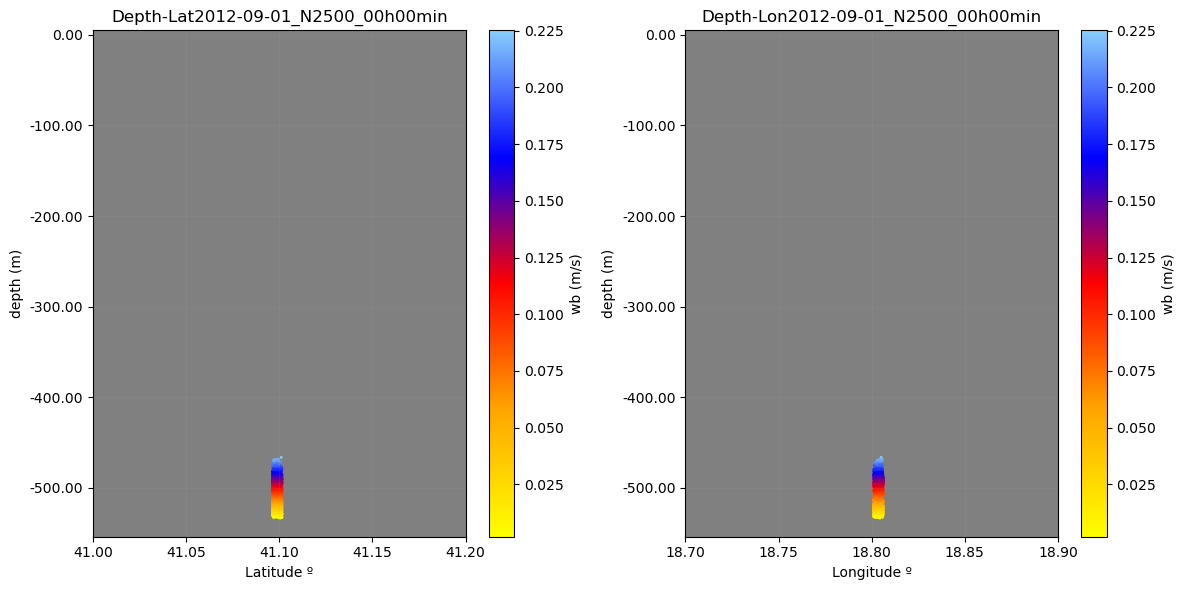

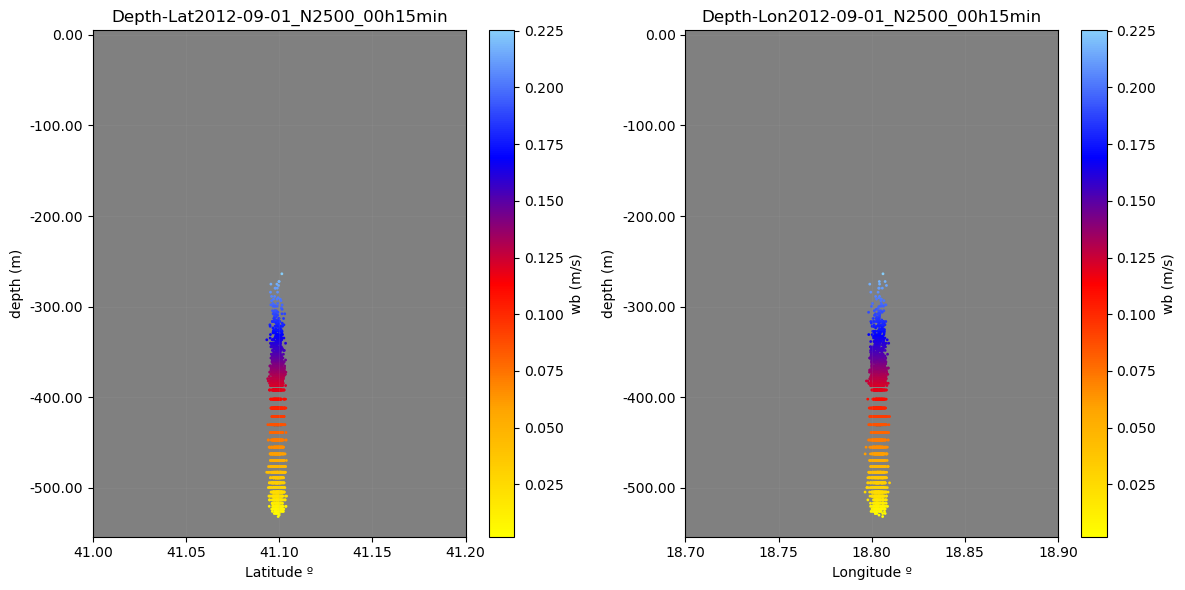

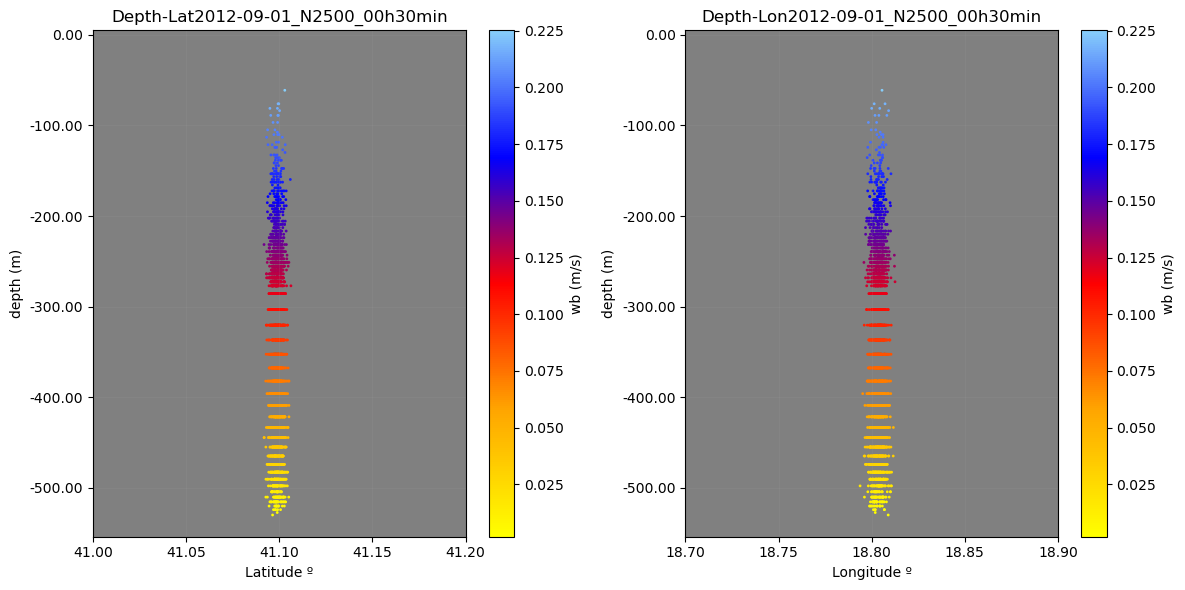

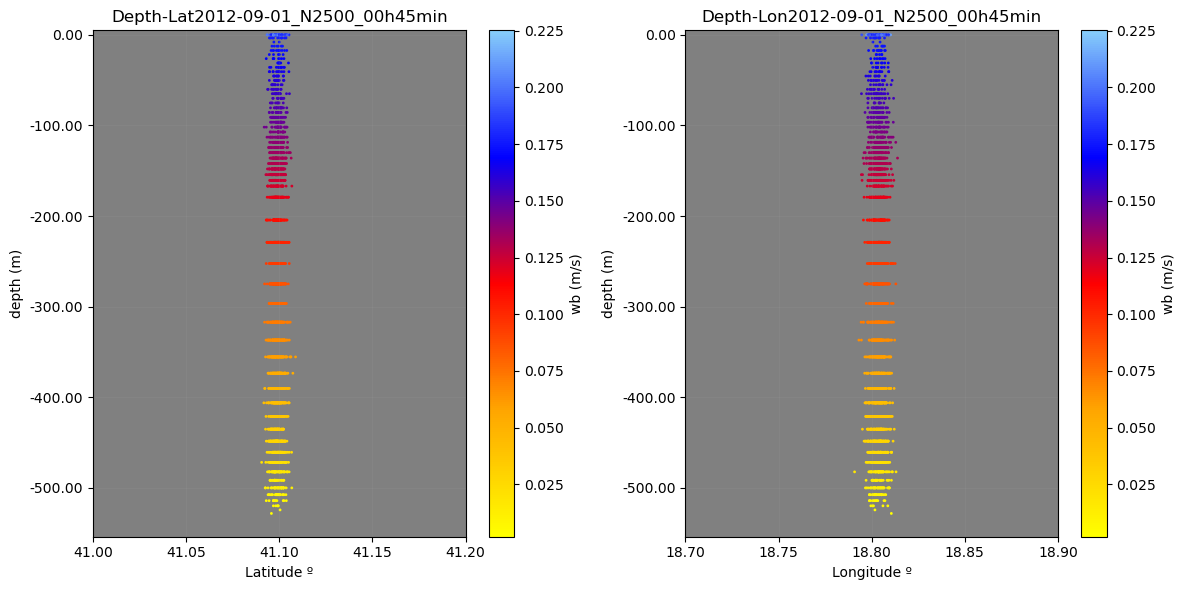

In [10]:
wbmin = -data_xarray['w_buoy'][:,:].max().values
wbmax = -data_xarray['w_buoy'][:,:].min().values

for obs in range (0,4,1):  

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # --- Plot 1: Latitude vs. Depth ---
    ax1 = axes[0]  # Access the first subplot
    ax1.set_facecolor('gray')
    ax1.grid(alpha=0.1)
    ax1.set_xlabel('Latitude º')
    ax1.set_ylabel('depth (m)')
    ax1.set_ylim(- init_depth - 20, 5)
    ax1.set_xlim(init_lat - 0.1, init_lat + 0.1) # Set latitude limits
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    colors = ["yellow", "orange", "red", "blue", "lightskyblue"]
    custom_cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

    vsc1 = ax1.scatter(data_xarray['lat'][:, obs], -data_xarray['z'][:, obs], marker='.', s=4, c=-data_xarray['w_buoy'][:, obs], cmap=custom_cmap, vmin=wbmin, vmax=wbmax)
    plt.colorbar(vsc1, ax=ax1, label='wb (m/s)')

    total_minutes = int(obs * output_dt)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    time_str = f"{hours:02d}h{minutes:02d}min"

    title1 = 'Depth-Lat' + np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str
    ax1.set_title(title1, fontsize=12)

    # --- Plot 2: Longitude vs. Depth ---
    ax2 = axes[1]  # Access the second subplot
    ax2.set_facecolor('gray')
    ax2.grid(alpha=0.1)
    ax2.set_xlabel('Longitude º')
    ax2.set_ylabel('depth (m)')
    ax2.set_xlim(init_lon - 0.1, init_lon + 0.1)
    ax2.set_ylim(- init_depth - 20, 5)
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    vsc2 = ax2.scatter(data_xarray['lon'][:, obs], -data_xarray['z'][:, obs], marker='.', s=4, c=-data_xarray['w_buoy'][:, obs], cmap=custom_cmap, vmin=wbmin, vmax=wbmax)
    plt.colorbar(vsc2, ax=ax2, label='wb (m/s)')

    title2 = 'Depth-Lon' + np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str
    ax2.set_title(title2, fontsize=12)

    # --- Adjust layout to prevent overlapping titles/labels ---
    plt.tight_layout()

    # Save the current figure to a file

    fig.savefig(os.path.join(plot_folder_path, 'Depth_'+np.datetime_as_string(speedxy.time_counter, "D") + '_N' + str(npart) + "_" + time_str + ".png"), bbox_inches='tight', dpi=300)
